# <h1 align="center"> **ENEL 503: Computer Vision (W2025)**

# <h2 align="center">**Lab3: Feature Extraction and Image Stitching**

***General Notes:***

* Download the lab3 images from D2L to your lab3 folder.
* You can add this folder to your Google Drive and access it through Google Colab or work in the real-time workspace, but you must upload your images there.
* This lab can be done in groups of 2 students. <ins>Only one submission with both names on the report</ins>
* The due date to submit this lab is March. 14 at 11:59 pm
* Read the lab instructions carefully and make sure you respond to all the open questions and coding tasks.
* After finishing your work, save this notebook with its ".iynb" extension and another version as "pdf". Then, upload both files to D2L Dropbox.
* Don't forget to write your names and student IDs below.

---


**Student Name:** Aarushi Roy Choudhury

**Student ID:** 30113987


---

Worked individually


---

## Objectives

In this lab, you will learn the following:

- Harris corner detector
- Simple descriptors and keypoint matching
- SIFT interest points
- Image stitching and panoramas


 This lab is adapted from:

 - Homeworks of the CS131 course at Stanford University.
 - Labs of the CSE 445 course at University of Washington

## Notes on Running This Notebook

Make sure to run each part from it's begining to ensure that you compute all of the dependencies of your current question and don't crossover variables with the same name from other questions. For example, don't run parts 4 and 5 and then return to run only the last cell of part 3; your panorama won't be using the right transformed images!  So long as you run each Part from it's beginning, you can run the Parts in any order.

When assembling your PDF, we recommend running all cells in order from the top of the notebook to prevent any of these discontinuity errors.

## Setup

### **Step 1**

In [158]:
# Run this part if you want to mount your Google Drive to Colab VM and
# work on your lab folder directly. Make sure to enter the correct path to your
# folder. Otherwise, you can work on the realtime workspace but you will need
# to upload your images.

from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# lab folder, e.g. 'ColabNotebooks/ENEL503/Lab2'
FOLDERNAME = 'Colab Notebooks/ENEL_503_Lab3' #None
assert FOLDERNAME is not None, "[!] Enter the foldername."
FullPath = '/content/drive/MyDrive/' + FOLDERNAME
print(FullPath)

import os
os.chdir(FullPath)
!pwd # check that your folder is the current working directory

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(FullPath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ENEL_503_Lab3
/content/drive/MyDrive/Colab Notebooks/ENEL_503_Lab3


### **Step 2**
Next, run the cells below to install the necessary libraries and packages.

In [131]:
# Check the Python version
!python --version

# Install the required packages (uncomment if not on Google Colab or not already installed on your env)
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python
# %pip install scikit-image
# %pip install scipy


Python 3.11.11


In [132]:
# Imports the print function from newer versions of python
from __future__ import print_function

# Numpy is the main package for scientific computing with Python.
# This will be one of our most used libraries in this class
import numpy as np

# The Time library helps us time code runtimes
import time

# PIL (Pillow) is a useful library for opening, manipulating, and saving images
from PIL import Image

# skimage (Scikit-Image) is a library for image processing
from skimage import io
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread

from scipy.ndimage import convolve
from scipy.spatial.distance import cdist

import cv2 as cv

from utils import pad, unpad, get_output_space, warp_image, plot_matches

# Matplotlib is a useful plotting library for python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Part 1 Harris Corner Detector (5 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$

Step 1 is already done for you in the function **`harris_corners`**. We used the [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operator), which computes smoothed gradients at each pixel in the x and y direction. See skimage documentation for [sobel_v](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel_v) and [sobel_h](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel_h) for more information on the sobel kernels and operators.

For step 3, we've created a uniform window function w for you in the starter code. You can assume that the window size will be odd.

Complete the function implementation of **`harris_corners`** and run the code below.

### Hint: There are two ways to solve this problem

**Vectorized**: If you want to be really efficient, you can use the function `scipy.ndimage.convolve`, and compute the response map R at every pixel all at once. If you're clever with your convolutions and determinant and trace calculations, you can compute the windowed gradients in $M$ ($\sum_{x,y} w(x,y) \cdot I_x^2$, and $\sum_{x,y} w(x,y) \cdot I_y^2$, and $\sum_{x,y} w(x,y) \cdot I_{xy}$), and then compute the response map without any for loops!

**Iterative**: The more intuitive solution is to iterate through each pixel of the image, compute $M$ based on the surrounding neighborhood of pixel gradients in $I_x$, $I_y$, and $I_{xy}$, and then compute the response map pixel $R(x,y)$.

Note that you'll want to explictly specify zero-padding to match the Harris response map definition. If you use zero-padding, both the vectorized and for-loop implementations will get you to the same answer!


In [133]:
def harris_corners(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.ndimage.filters.convolve,
        which is already imported above. If you use convolve(), remember to
        specify zero-padding to match our equations, for example:

            out_image = convolve(in_image, kernel, mode='constant', cval=0)

        You can also use 'for' nested loops, like you did with filtering in lab2,
        to compute M and the subsequent Harris corner response for each output
        pixel, intead of using convolve().

    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response = np.zeros((H, W))

    # 1. Compute x and y derivatives (I_x, I_y) of an image
    I_x = filters.sobel_v(img) # I_x = dx
    I_y = filters.sobel_h(img) # I_y = dy

    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

    # 2. Compute products of derivatives
    I_x2 = I_x ** 2
    I_y2 = I_y ** 2
    I_xy = I_x * I_y

    # 3. Compute sums within the window using convolution, so no loops needed
    S_x2 = convolve(I_x2, window, mode='constant', cval=0)
    S_y2 = convolve(I_y2, window, mode='constant', cval=0)
    S_xy = convolve(I_xy, window, mode='constant', cval=0)

    # 4. Compute determinant and trace
    det_M = (S_x2 * S_y2) - (S_xy ** 2)
    trace_M = S_x2 + S_y2

    # 5. Compute Harris response
    response = det_M - k * (trace_M ** 2)

    ### END YOUR CODE (DON'T DELETE THIS LINE)

    return response

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the tic-tac-toe grids and shapes in the output corner response image. Compare the location of the detected corners against our solution using the code below. It is okay if the background seems different. The most important thing is the location of the detected corners.

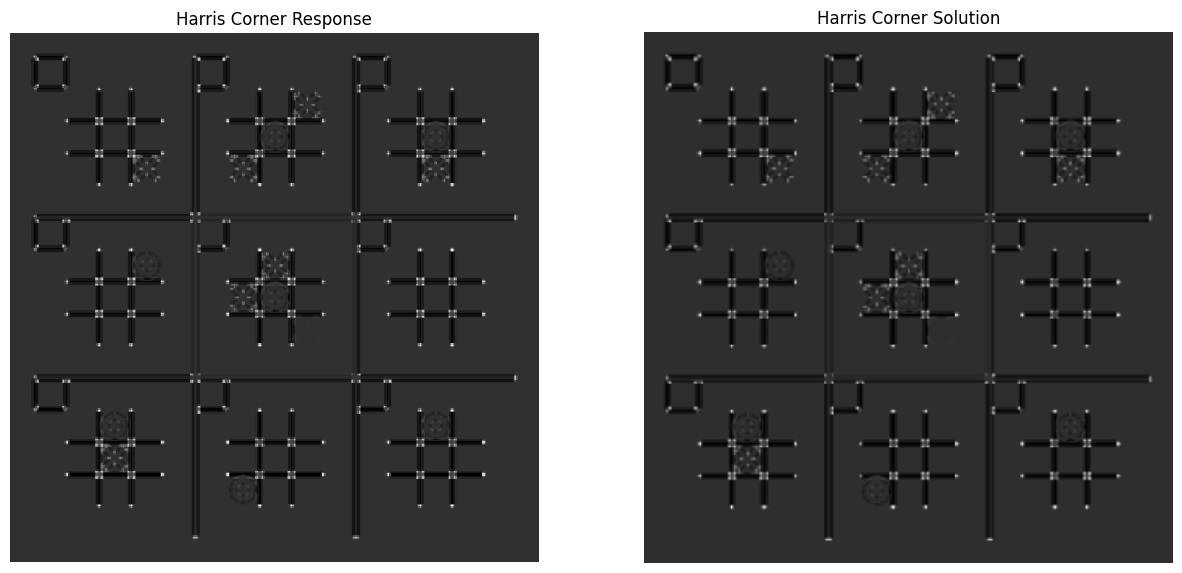

In [134]:
img = imread('tictactoe.png', as_gray=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.subplot(1,2,1)
plt.imshow(response)
plt.axis('off')
plt.title('Harris Corner Response')

plt.subplot(1,2,2)
plt.imshow(imread('tictactoe_solution_harris.png', as_gray=True))
plt.axis('off')
plt.title('Harris Corner Solution')

plt.show()

 Now, the function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints. Run the following code to check your solution against our solution

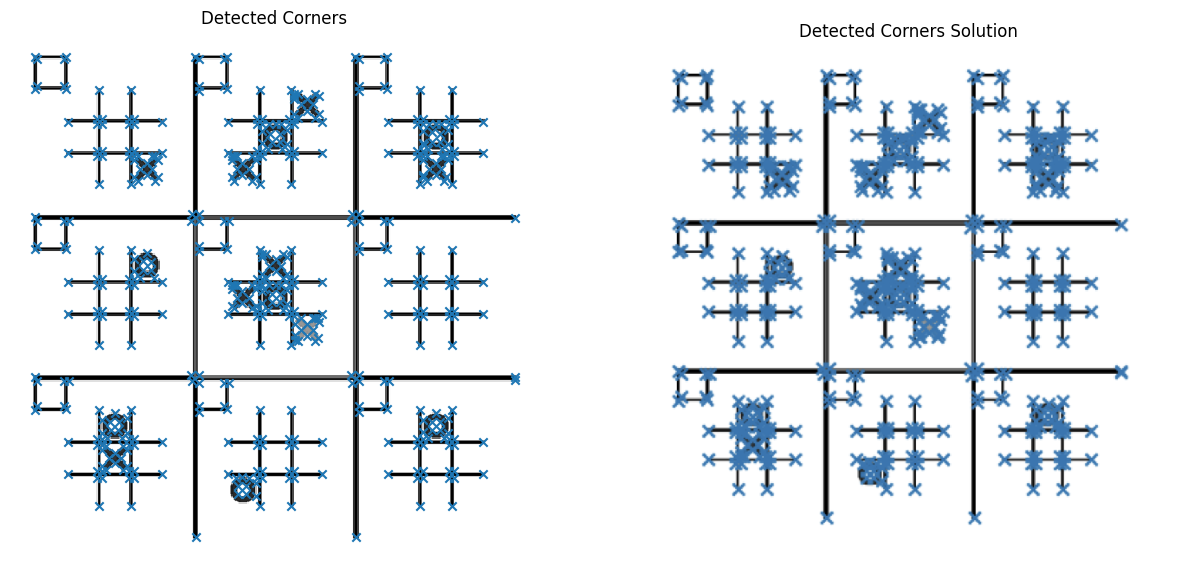

In [135]:
# Perform non-maximum suppression in response map
# and output corner coordinates
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.subplot(1,2,1)
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')

plt.subplot(1,2,2)
plt.imshow(imread('tictactoe_solution_detected_corners.png'))
plt.axis('off')
plt.title('Detected Corners Solution')

plt.show()

# Part 2 Describing and Matching Keypoints

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vectors called *descriptors*.

## 2.1 Creating Descriptors (3 points)

In this section, you are going to implement the **`simple_descriptor`** function, where each keypoint is described by the normalized intensity of a small patch around it.


In [136]:
def simple_descriptor(patch):
    """
    Describe the patch by normalizing the image values into a standard
    normal distribution (having mean of 0 and standard deviation of 1)
    and then flattening into a 1D array.

    Recall that normalization into a standard normal distribution is
    performed using the formula:

    x_norm = (x - x_mean)/x_std

    The normalization will make the descriptor more robust to change
    in lighting condition.

    Hint:
        In this case of normalization, if a denominator is zero, divide by 1 instead.

    Args:
        patch: grayscale image patch of shape (H, W)

    Returns:
        feature: 1D array of shape (H * W)
    """
    feature = []
    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

    # Compute mean and standard deviation of patch
    mean = np.mean(patch)
    std = np.std(patch)

    # No division by zero
    if std == 0:
        std = 1

    # Normalize patch
    normalized_patch = (patch - mean) / std

    # Flatten to a 1D feature vector
    feature = normalized_patch.flatten()

    ### END YOUR CODE (DON'T DELETE THIS LINE)
    return feature

Keypoints 1 shape =  (396, 2)
Keypoints 2 shape =  (627, 2)


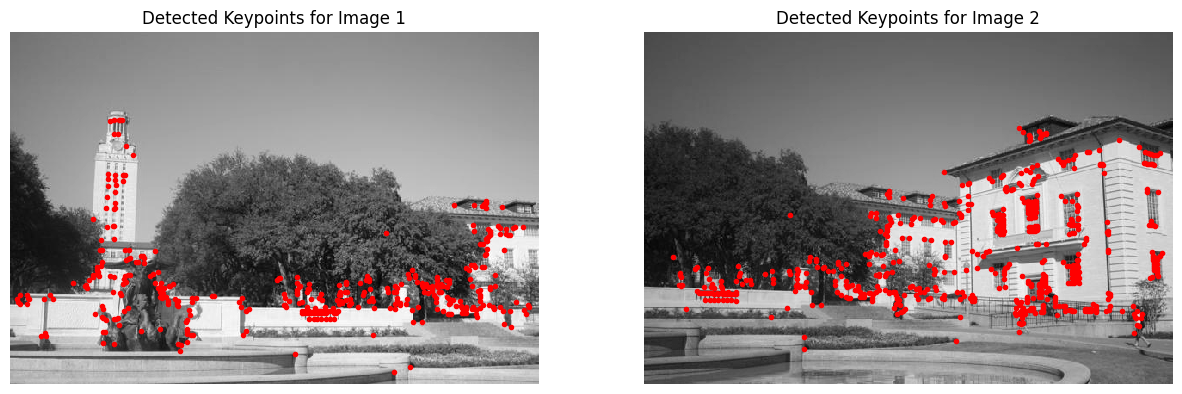

In [137]:
img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

print("Keypoints 1 shape = ", keypoints1.shape)
print("Keypoints 2 shape = ", keypoints2.shape)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='.',color='red')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='.',color='red')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()


## 2.2 Matching Descriptors (5 points)

Next, implement the **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: for each descriptor in image 1, if the distance to the closest descriptor in image 2 is significantly (by a given factor) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

**Checking your answer*: you should see an identical matching of keypoints as the provided solution image, but the precise colors of each line will change with every run of keypoint matching so colors do not need to match.*

Think about why this method of keypoint matching is not commutative (Ungraded).

In [138]:
def describe_keypoints(image, keypoints, desc_func, patch_size=16):
    """
    Args:
        image: grayscale image of shape (H, W)
        keypoints: 2D array containing a keypoint (y, x) in each row
        desc_func: function that takes in an image patch and outputs
            a 1D feature vector describing the patch
        patch_size: size of a square patch at each keypoint

    Returns:
        desc: array of features describing the keypoints
    """

    image.astype(np.float32)
    desc = []

    for i, kp in enumerate(keypoints):
        y, x = kp
        patch = image[y-(patch_size//2):y+((patch_size+1)//2),
                      x-(patch_size//2):x+((patch_size+1)//2)]
        desc.append(desc_func(patch))
    return np.array(desc)

In [139]:
def match_descriptors(desc1, desc2, threshold=0.5):
    """
    Match the feature descriptors by finding distances between them. A match is formed
    when the distance to the closest vector is much smaller than the distance to the
    second-closest, that is, the ratio of the distances should be STRICTLY SMALLER
    than the threshold (NOT equal to). Return the matches as pairs of vector indices.

    Hint:
        The Numpy functions np.sort, np.argmin, np.asarray might be useful

        The Scipy function cdist calculates Euclidean distance between all
        pairs of inputs
    Args:
        desc1: an array of shape (M, P) holding descriptors of size P about M keypoints
        desc2: an array of shape (N, P) holding descriptors of size P about N keypoints

    Returns:
        matches: an array of shape (Q, 2) where each row holds the indices of one pair
        of matching descriptors
    """
    matches = []

    M = desc1.shape[0]
    dists = cdist(desc1, desc2,'euclidean')

    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

    # Loop through each descriptor in desc1
    for i in range(dists.shape[0]):
        # Sort distances for the current descriptor to find closest and second closest
        sorted_indices = np.argsort(dists[i])
        closest, second_closest = sorted_indices[0], sorted_indices[1]

        # Compute the distance ratio
        ratio = dists[i][closest] / dists[i][second_closest]

        # Apply ratio test for a good match
        if ratio < threshold:
            matches.append([i, closest])

    ### END YOUR CODE (DON'T DELETE THIS LINE)

    return np.array(matches)

Desc1 shape =  (396, 25)
Desc2 shape =  (627, 25)


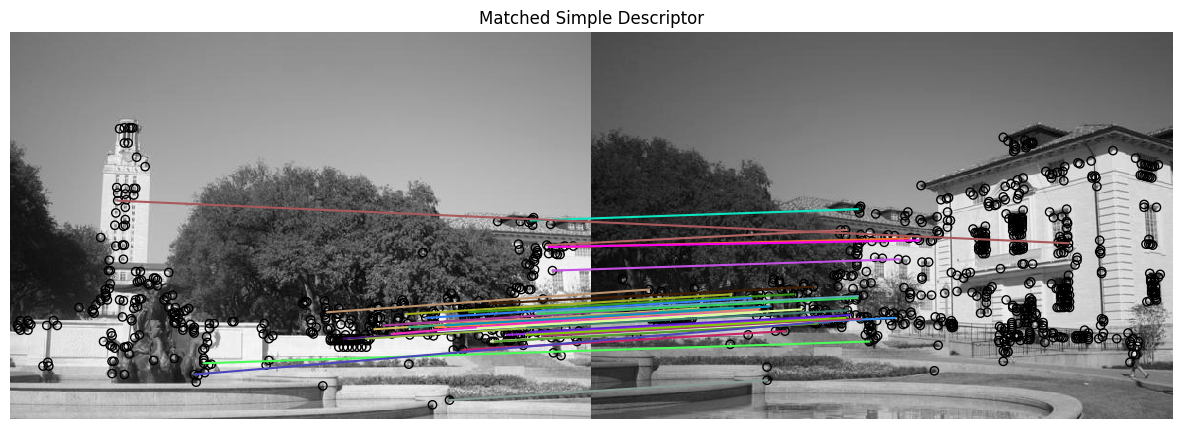

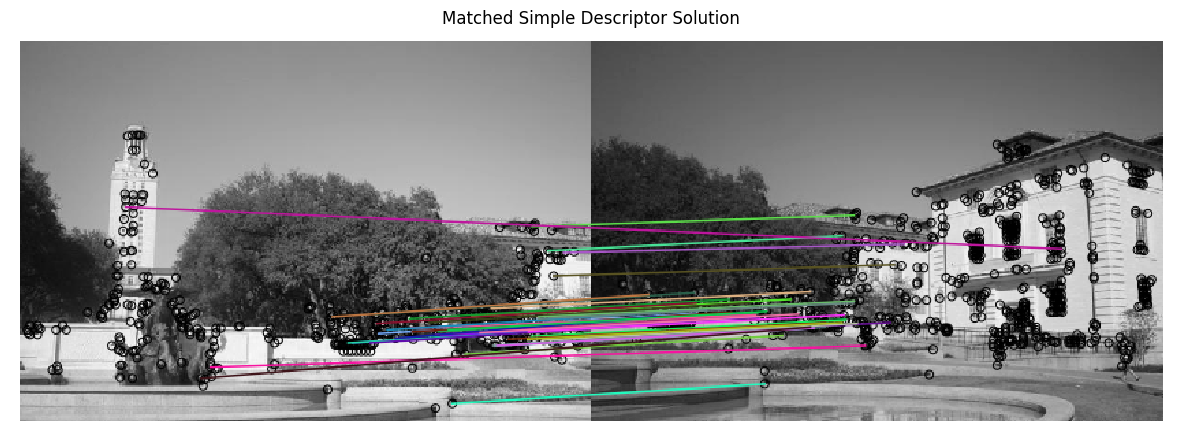

In [140]:
# Set seed to compare output against solution
np.random.seed(131)

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

print("Desc1 shape = ", desc1.shape)
print("Desc2 shape = ", desc2.shape)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched Simple Descriptor')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

plt.imshow(imread('solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

# Part 3 Describing and Matching Keypoints with SIFT

In 2004, D.Lowe, University of British Columbia, came up with a new algorithm, Scale Invariant Feature Transform (SIFT) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors. We are now going to determine the keypoints of an image using Open CV functions.

## 3.1 Creating Descriptors (2 points)

In this section, you are going to implement an Open CV sift function to find the keypoints and descriptors. Then you are going to map the keypoints.

In [141]:
# Loading the image
img1 = imread('uttower1.jpg')
img2 = imread('uttower2.jpg')

 # Converting image to grayscale
img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

### YOUR CODE HERE (DON'T DELETE THIS LINE)

# create SIFT detector
sift = cv.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1_sift, desc1_sift = sift.detectAndCompute(img1, None)
kp2_sift, desc2_sift = sift.detectAndCompute(img2, None)

### END YOUR CODE (DON'T DELETE THIS LINE)

print("Number of Keypoints 1 = ", len(kp1_sift)) #change the variable name kp1_sift to match your code
print("Number of Keypoints 2 = ", len(kp2_sift)) #change the variable name kp2_sift to match your code

Number of Keypoints 1 =  2006
Number of Keypoints 2 =  1604


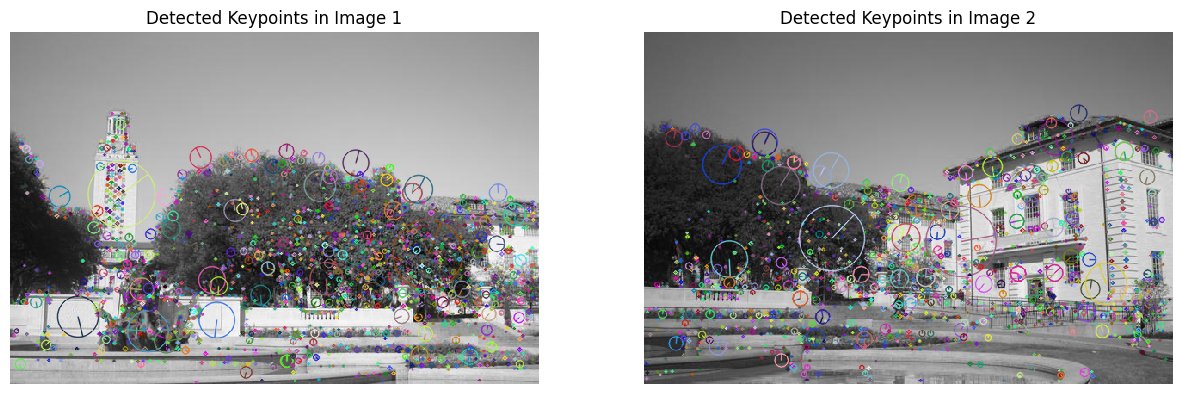

In [142]:
# Marking the keypoint on the image using circles
img1_kp = cv.drawKeypoints(img1, kp1_sift, img1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv.drawKeypoints(img2, kp2_sift, img2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1_kp)
plt.axis('off')
plt.title('Detected Keypoints in Image 1')

plt.subplot(1,2,2)
plt.imshow(img2_kp)
plt.axis('off')
plt.title('Detected Keypoints in Image 2')
plt.show()


## 3.2 Matching Descriptors with SIFT (3 points)
Next, match the descriptors with the `BFMatcher()` function with its default parameters. Sort your matches based on the order of their `distance` so that we can disply only the strongest matches. You can find different way to sort the matches online.


In [143]:
### YOUR CODE HERE (DON'T DELETE THIS LINE)

# Create a BFMatcher object with default parameters
bf = cv.BFMatcher()

# Match descriptors using BFMatcher
matches = bf.match(desc1_sift, desc2_sift)

# Sort matches based on distance (lower distance = better match)
matches = sorted(matches, key=lambda x: x.distance)

### END YOUR CODE (DON'T DELETE THIS LINE)

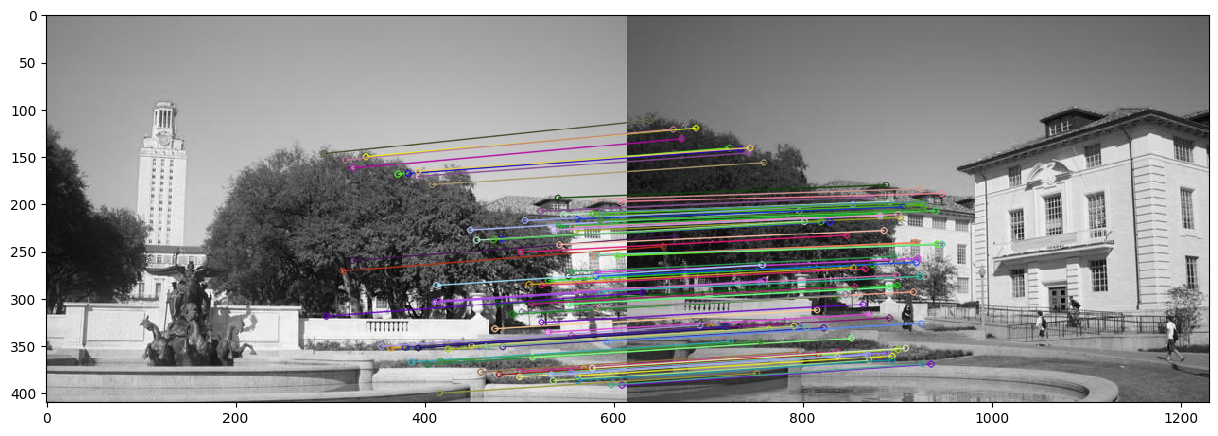

In [144]:
# display the strongest 100 matches (assuming you did the sorting in the previous step). You can display more matches to see how weak matches can be a source of error.
img3 = cv.drawMatches(img1,kp1_sift,img2,kp2_sift,matches[:100],None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)

# Part 4: Image Stitching
## 4.1 Transformation Estimation (2 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an **affine transformation** matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** below

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*

In [145]:
def fit_affine_matrix(p1, p2, to_pad=True):
    """
    Fit affine matrix such that p2 * H = p1. First, pad the descriptor vectors
    with a 1 using pad() to convert to homogeneous coordinates, then return
    the least squares fit affine matrix in homogeneous coordinates.

    Hint:
        You can use np.linalg.lstsq function to solve the problem.

        Explicitly specify np.linalg.lstsq's new default parameter rcond=None
        to suppress deprecation warnings.

    Args:
        p1: an array of shape (M, P) holding descriptors of size P about M keypoints
        p2: an array of shape (M, P) holding descriptors of size P about M keypoints

    Return:
        H: a matrix of shape (P+1, P+1) that transforms p2 to p1 in homogeneous
        coordinates
    """

    assert (p1.shape[0] == p2.shape[0]),\
        'Different number of points in p1 and p2'

    if to_pad:
        p1 = pad(p1)
        p2 = pad(p2)

    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

    # Solve the least squares problem: p2 * H = p1
    H = np.linalg.lstsq(p2, p1, rcond=None)[0]

    ### END YOUR CODE (DON'T DELETE THIS LINE)

    # Sometimes numerical issues cause least-squares to produce the last
    # column which is not exactly [0, 0, 1]
    # Correct the last row to ensure homogeneity
    H[:,2] = np.array([0, 0, 1])
    return H

In [146]:
# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)
print(H)
# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

[[ 1.25  2.5   0.  ]
 [-5.75 -4.5   0.  ]
 [ 0.25 -1.    1.  ]]
Implementation correct!


After checking that your **`fit_affine_matrix`** function is running correctly, run the following code to apply it to images.

Images will be warped and image 2 will be mapped to image 1.

Output shape: [493 631]
Offset: [-37.17230306   0.        ]


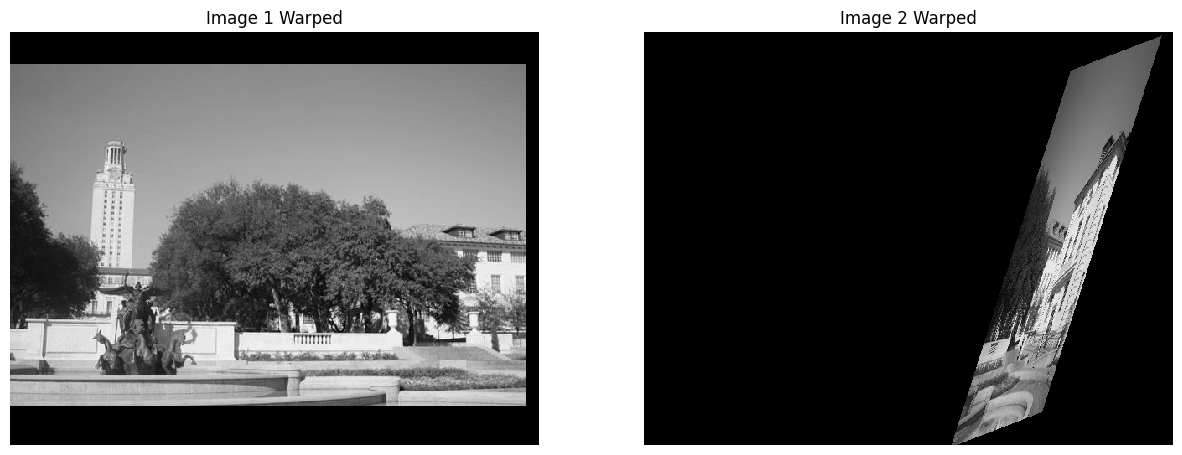

In [147]:
img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

np.random.seed(131)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=5)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=5)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)


p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 Warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 Warped')
plt.axis('off')

plt.show()

Next, the two warped images are merged to get a panorama.

Your panorama may not look good at this point, but we will later use other techniques to get a better result!

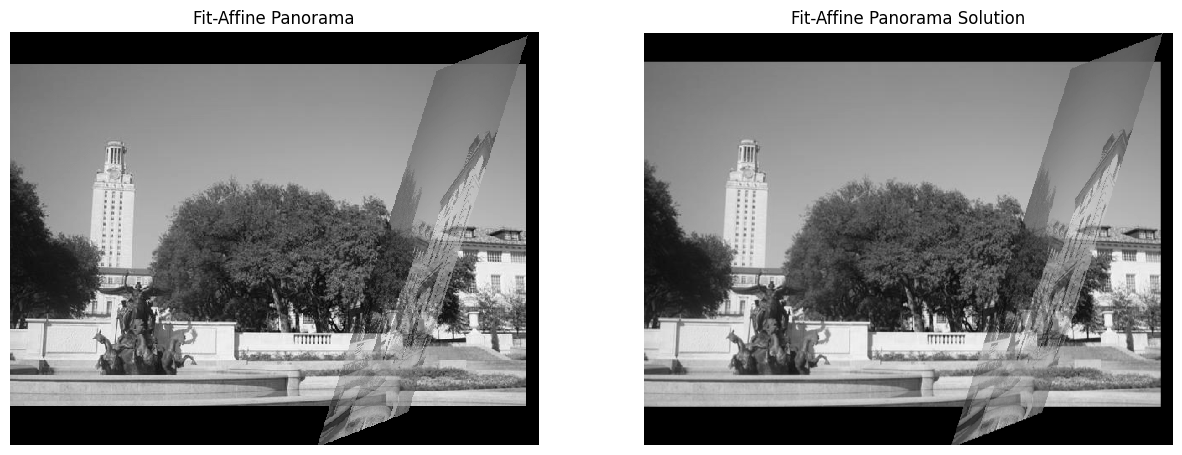

In [148]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.subplot(1,2,1)
plt.imshow(normalized)
plt.axis('off')
plt.title('Fit-Affine Panorama')

plt.subplot(1,2,2)
plt.imshow(imread('solution_fit_affine_panorama.png'))
plt.axis('off')
plt.title('Fit-Affine Panorama Solution')
plt.show()

## 4.2. RANSAC (5 points)
Rather than directly feeding all our keypoint matches into **``fit_affine_matrix``**, we can use **RANSAC** ("RANdom SAmple Consensus") to select only "inliers" to use for computing the transformation matrix.

Use Euclidean distance as a measure of inliers vs. outliers.


The steps of RANSAC are:
1. Select random set of matches
2. Compute affine transformation matrix
      - You can call your **`fit_affine_matrix`** function for this. **Make sure to explicitly pass in `to_pad=False`.**
3. Find inliers using the given threshold
4. Repeat and keep the largest set of inliers (use >, i.e. break ties by whichever set is seen first)
5. Re-compute least-squares estimate on all of the inliers

Implement **`ransac`** below.

In [149]:
def ransac(keypoints1, keypoints2, matches, n_iters=200, threshold=20):
    """
    Use RANSAC to find a robust affine transformation:

        1. Select random set of matches
        2. Compute affine transformation matrix
        3. Compute inliers via Euclidean distance
        4. Keep the largest set of inliers (use >, i.e. break ties by whichever set is seen first)
        5. Re-compute least-squares estimate on all of the inliers

    Update max_inliers as a boolean array where True represents the keypoint
    at this index is an inlier, while False represents that it is not an inlier.

    Hint:
        You can use fit_affine_matrix to compute the affine transformation matrix.
        Make sure to pass in to_pad=False, since we pad the matches for you here.

        You can compute elementwise boolean operations between two numpy arrays,
        and use boolean arrays to select array elements by index:
        https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing

    Args:
        keypoints1: M1 x 2 matrix, each row is a point
        keypoints2: M2 x 2 matrix, each row is a point
        matches: N x 2 matrix, each row represents a match
            [index of keypoint1, index of keypoint 2]
        n_iters: the number of iterations RANSAC will run
        threshold: the threshold to find inliers

    Returns:
        H: a robust estimation of affine transformation from keypoints2 to
        keypoints 1
    """

    # Copy matches array, to avoid overwriting it
    orig_matches = matches.copy()
    matches = matches.copy()

    N = matches.shape[0]
    n_samples = int(N * 0.2)

    matched1 = pad(keypoints1[matches[:,0]])
    matched2 = pad(keypoints2[matches[:,1]])

    max_inliers = np.zeros(N, dtype=bool) # indexes of inliers in the final model
    n_inliers = 0                         # number of inliers in the final model
    best_H_temp = None

    # RANSAC iteration start

    # Note: while there're many ways to do random sampling, we use
    # `np.random.shuffle()` followed by slicing out the first `n_samples`
    # matches.
    # Sample with this code:
    for i in range(n_iters):
        # 1. Select random set of matches
        np.random.shuffle(matches)
        samples = matches[:n_samples]
        sample1 = pad(keypoints1[samples[:,0]])
        sample2 = pad(keypoints2[samples[:,1]])

    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

        # 2. Compute affine transformation matrix, map sample2 to sample1
        H_temp = fit_affine_matrix(sample1, sample2, to_pad=False)

        # 3. Compute inliers via Euclidean distance
        # Apply the transformation to all keypoints from image 2
        predicted = matched2 @ H_temp
        # Compute Euclidean distances between predicted points and actual keypoints from image 1
        dists = np.linalg.norm(predicted[:, :2] - matched1[:, :2], axis=1)
        current_inliers = dists < threshold

        # 4. Keep the largest set of inliers
        if np.sum(current_inliers) > n_inliers:
            n_inliers = np.sum(current_inliers)
            max_inliers = current_inliers.copy()
            best_H_temp = H_temp

    # 5. Re-compute least-squares estimate on all of the inliers
    if n_inliers > 0:
          inlier_points1 = pad(keypoints1[orig_matches[max_inliers, 0]])
          inlier_points2 = pad(keypoints2[orig_matches[max_inliers, 1]])
          H = fit_affine_matrix(inlier_points1, inlier_points2, to_pad=False)
    else:
          # Fallback to the best found transformation if no inliers meet the threshold
          H = best_H_temp if best_H_temp is not None else np.eye(3)

    ### END YOUR CODE (DON'T DELETE THIS LINE)

    return H, orig_matches[max_inliers]

Now, run through the following cells to get a panorama. You'll be able to see the difference from the result we got before without RANSAC.

Robust matches shape =  (14, 2)
H = 
 [[ 1.01796212e+00  2.42214470e-02  0.00000000e+00]
 [-2.92511861e-02  1.03559397e+00  0.00000000e+00]
 [ 2.03684578e+01  2.58675281e+02  1.00000000e+00]]


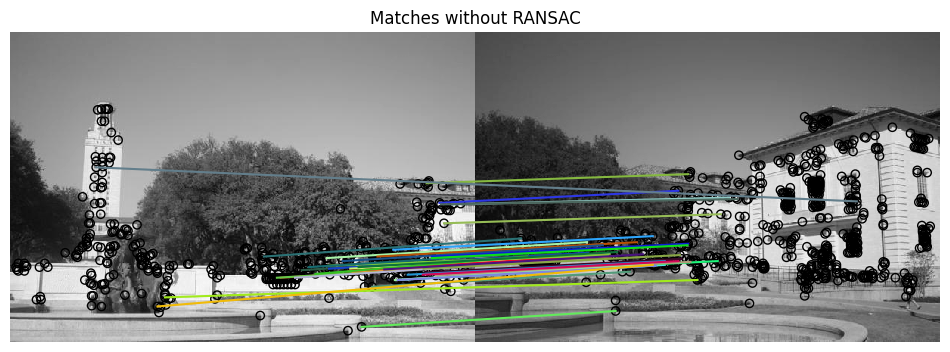

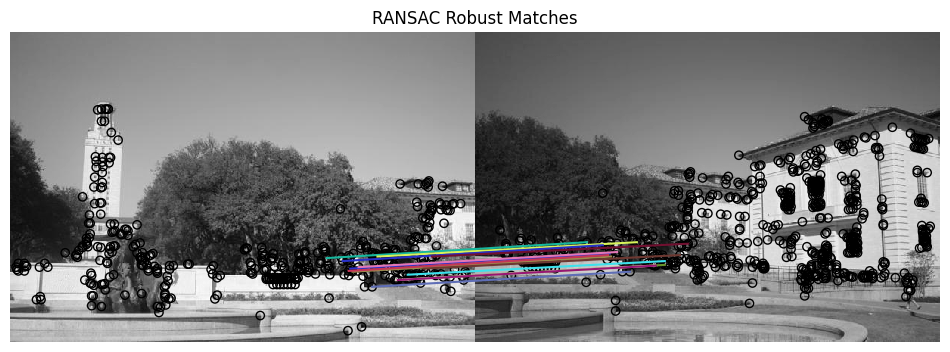

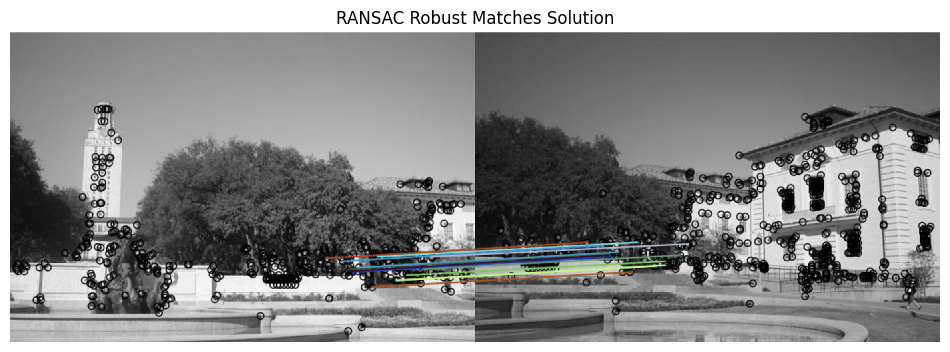

In [150]:
# Set seed to compare output against solution image
np.random.seed(131)

H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)


# Visualize matches without RANSAC
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.axis('off')
plt.title('Matches without RANSAC')
plt.show()


# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.title('RANSAC Robust Matches')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Robust Matches Solution')
plt.show()

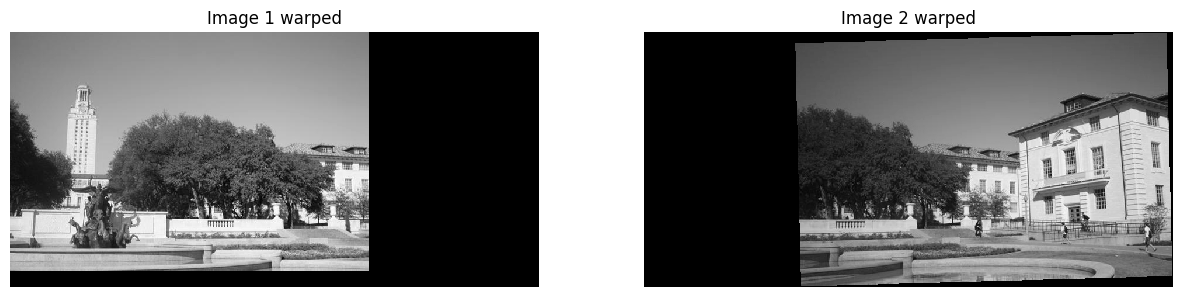

In [151]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

We can now use the tranformation matrix $H$ computed using the robust matches to warp our images and create a better-looking panorama.

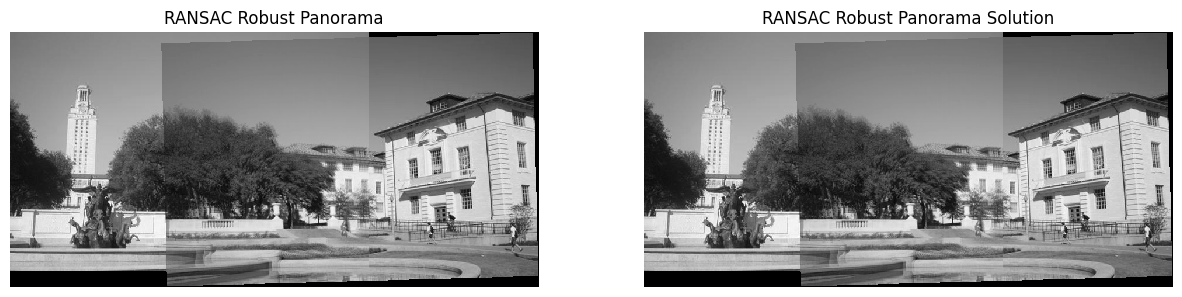

In [152]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.subplot(1,2,1)
plt.imshow(normalized)
plt.axis('off')
plt.title('RANSAC Robust Panorama')

plt.subplot(1,2,2)
plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Robust Panorama Solution')
plt.show()

## 4.3 Better Image Merging (5 points)
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. Using a very simple technique called linear blending, we can smooth out a lot of these artifacts.

Currently, all the pixels in the overlapping region are weighted equally. However, since the pixels at the left and right ends of the overlap are very well complemented by the pixels in the other image, they can be made to contribute less to the final panorama.

Linear blending can be done with the following steps:

1. Define left and right margins for blending to occur between
2. Define a weight matrix for image 1 such that:
    - From the left of the output space to the left margin the weight is 1
    - From the left margin to the right margin, the weight linearly decrements from 1 to 0
3. Define a weight matrix for image 2 such that:
    - From the right of the output space to the right margin the weight is 1
    - From the left margin to the right margin, the weight linearly increments from 0 to 1
4. Apply the weight matrices to their corresponding images
5. Combine the images

In **`linear_blend`** below, implement the linear blending scheme to make the panorama look more natural.

In [153]:
def linear_blend(img1_warped, img2_warped):
    """
    Linearly blend img1_warped and img2_warped by following the steps:

    1. Define left and right margins (already done for you)
    2. Define a weight matrices for img1_warped and img2_warped
        np.linspace and np.tile functions will be useful
    3. Apply the weight matrices to their corresponding images
    4. Combine the images

    Args:
        img1_warped: Refernce image warped into output space
        img2_warped: Transformed image warped into output space

    Returns:
        merged: Merged image in output space
    """

    out_H, out_W = img1_warped.shape # Height and width of output space
    img1_mask = (img1_warped != 0)  # Mask == 1 inside the image
    img2_mask = (img2_warped != 0)  # Mask == 1 inside the image

    # Find column of middle row where warped image 1 ends
    # This is where to end weight mask for warped image 1
    right_margin = out_W - np.argmax(np.fliplr(img1_mask)[out_H//2, :].reshape(1, out_W), 1)[0]

    # Find column of middle row where warped image 2 starts
    # This is where to start weight mask for warped image 2
    left_margin = np.argmax(img2_mask[out_H//2, :].reshape(1, out_W), 1)[0]

    ### YOUR CODE HERE (DON'T DELETE THIS LINE)

    # Create a weight row for image 1: full weight of 1 before left_margin,
    # then linearly decaying from 1 to 0 between left_margin and right_margin,
    # and 0 beyond right_margin.
    x = np.arange(out_W)
    w1_row = np.ones(out_W, dtype=np.float32)
    if right_margin > left_margin:
        w1_row[left_margin:right_margin] = np.linspace(1, 0, right_margin - left_margin, endpoint=True)
    else:
        # If no overlap, ensure weight remains 1
        w1_row[:] = 1.0

    # Create a weight row for image 2: weight 0 before left_margin,
    # then linearly increasing from 0 to 1 between left_margin and right_margin,
    # and full weight of 1 beyond right_margin.
    w2_row = np.zeros(out_W, dtype=np.float32)
    if right_margin > left_margin:
        w2_row[left_margin:right_margin] = np.linspace(0, 1, right_margin - left_margin, endpoint=True)
    w2_row[right_margin:] = 1.0

    # Tile the weight rows to full image dimensions.
    w1 = np.tile(w1_row, (out_H, 1))
    w2 = np.tile(w2_row, (out_H, 1))

    # Apply weights to the images.
    img1_weighted = img1_warped * w1
    img2_weighted = img2_warped * w2

    # Combine the images.
    merged = img1_weighted + img2_weighted

    ### END YOUR CODE (DON'T DELETE THIS LINE)

    return merged

Now let's see how linear blending improves our result.

EC1 keypoints1 shape =  (396, 2)
EC1 keypoints2 shape =  (627, 2)
EC1 desc1 shape =  (396, 25)
EC1 desc2 shape =  (627, 25)
Robust matches shape =  (14, 2)
H = 
 [[ 1.01796212e+00  2.42214470e-02  0.00000000e+00]
 [-2.92511861e-02  1.03559397e+00  0.00000000e+00]
 [ 2.03684578e+01  2.58675281e+02  1.00000000e+00]]
Output shape: [438 906]
Offset: [0. 0.]


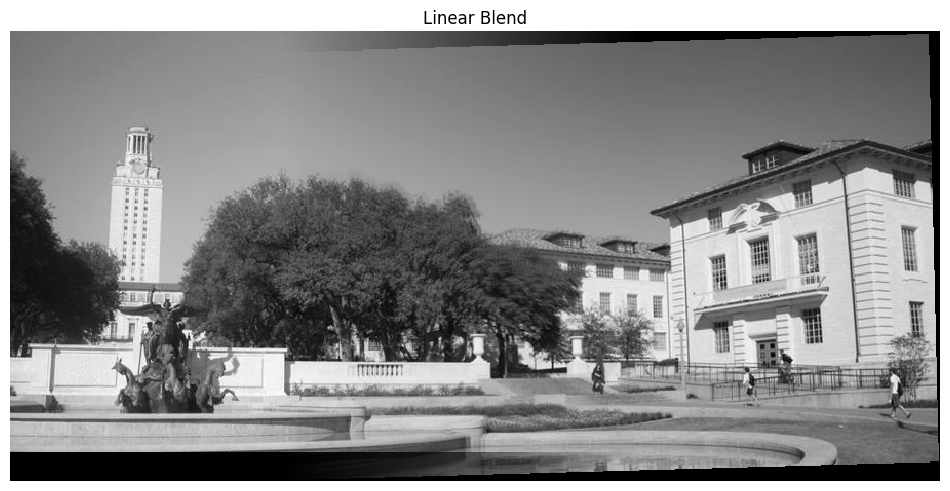

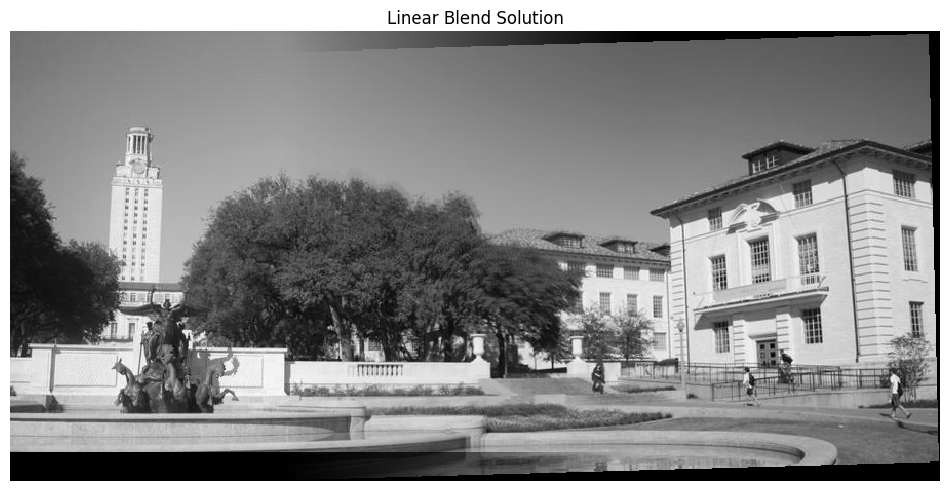

In [154]:
img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

# Set seed to compare output against solution
np.random.seed(131)

# Detect keypoints in both images
ec1_keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)
ec1_keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)

print("EC1 keypoints1 shape = ", ec1_keypoints1.shape)
print("EC1 keypoints2 shape = ", ec1_keypoints2.shape)

# Extract features from the corners
ec1_desc1 = describe_keypoints(img1, ec1_keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=5)
ec1_desc2 = describe_keypoints(img2, ec1_keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=5)

print("EC1 desc1 shape = ", ec1_desc1.shape)
print("EC1 desc2 shape = ", ec1_desc2.shape)

# Match descriptors in image1 to those in image2
ec1_matches = match_descriptors(ec1_desc1, ec1_desc2, 0.7)

H, robust_matches = ransac(ec1_keypoints1, ec1_keypoints2, ec1_matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Merge the warped images using linear blending scheme
merged = linear_blend(img1_warped, img2_warped)

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.imshow(merged)
plt.axis('off')
plt.title('Linear Blend')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.imshow(imread('solution_linear_blend.png'))
plt.axis('off')
plt.title('Linear Blend Solution')
plt.show()

In [ ]:
%pip install nbconvert

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc.

In [159]:
!jupyter nbconvert --to pdf ENEL503_Lab3_AarushiRoyChoudhury.ipynb

[NbConvertApp] Converting notebook ENEL503_Lab3_AarushiRoyChoudhury.ipynb to pdf
[NbConvertApp] Support files will be in ENEL503_Lab3_AarushiRoyChoudhury_files/
[NbConvertApp] Making directory ./ENEL503_Lab3_AarushiRoyChoudhury_files
[NbConvertApp] Writing 122183 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 4143920 bytes to ENEL503_Lab3_AarushiRoyChoudhury.pdf
